In [2]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd
from python_speech_features import logfbank, mfcc
from scipy import stats
# Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa

#from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

%matplotlib inline

In [3]:
## Ces fonctions return le signal correspondant au mot + context

# On prend 1.1 s pour chaque mot (Abdel Approach)
def get_time(deb, fin, duree_audio, max_duree) :
    if (duree_audio>=max_duree) :
        duree = (float(fin)-float(deb))
        ecart = (float(max_duree-duree)/2.0)
        if (fin+ecart > duree_audio) :
            fin = duree_audio
            deb = fin - max_duree

        elif (deb-ecart < 0) :
            deb = 0
            fin = max_duree

        else :
            deb -= ecart
            fin += ecart

    return round(deb,2), round(fin,2)
# On limite la durée à 1.1 s et les contextes (gauche et droit) à duree_ctxt
def time(deb, fin, duree_audio, max_duree, duree_ctxt) :
    if (duree_audio>=max_duree) :
        duree = (float(fin)-float(deb))
        nv_deb = deb - min(duree_ctxt,deb)
        nv_fin = fin + min(duree_ctxt, duree_audio-fin)   

    return max(0,round(nv_deb,2)), min(round(nv_fin,2),duree_audio)

In [4]:
######### 3D-matrix of features ############

## Extract the logFbank coefficient
def features_extraction(DF, nfilt, context, max_duree=1.1, duree_ctxt=0.05) :

    labels = []
    ft = []
    #d = DF.Time_end - DF.Time_begin
    #ind = d[d<duree_noCtxt].index
    for i in range(len(DF)):
        # Charger l'audio
        audio_path = '.'+DF.Path.iloc[i]
        #samples, sr= librosa.load(audio_path)
        sr, samples = wavfile.read(audio_path)
        # charger le DF correspondant
        deb = DF.Time_begin.iloc[i]
        fin = DF.Time_end.iloc[i]
        duree_audio = (float(len(samples))/float(sr))
        if context :
            #deb, fin = get_time(deb, fin, duree_audio, max_duree)  #Abdel Approach
            deb, fin = time(deb, fin, duree_audio, max_duree, duree_ctxt)   ## 2nd approach
        # Le nouveau signal
        y = samples[int(deb*sr):int(fin*sr)+1]    
        fbank_feat = logfbank(y,sr,nfilt=nfilt, winlen=0.02, nfft=1024)

        nb_fen = int(max_duree*100)-1
        features = np.zeros((nb_fen, nfilt))
        nrow = min(len(fbank_feat), nb_fen)
        features[:nrow,:] = fbank_feat[:nrow,:]
             
        ft.append(features)
        labels.append(DF.Label.iloc[i])

    m = np.zeros((len(ft), nb_fen,nfilt))
    for i in range(len(ft)) :
        fti = ft[i]
        m[i,:len(fti),:] = fti
    return m, labels

## Return the 3D-matrix of features that will be given to the CNN
def X_features(features, nbl, nmels) :
    X = features[:,:nbl,:]
    X = X.reshape(len(X),1,nbl,nmels)
    return X

###### 2D-Matrice des features (stats)  ##############

## Remove the 0-padding to calculate statistics
def mat_reshape(mat) :
    for i in range(len(mat)) :
        ncol = mat.shape[1]
        if sum(mat[i,:] == np.repeat(0,ncol))==ncol :
            return i

## get stats giving a matrix of coeff
def stats_features(features) :
    X = np.zeros((len(features),160))
    i = 0
    for f in features : 
        ind = mat_reshape(f)
        stat = stats.describe(f[:ind,:])
        st = np.asarray([s for s in stat][2:])
        vect = np.ndarray.flatten(st)
        if (sum(np.isnan(vect))==0) :
            X[i,:] = vect
            i+=1
    return X

In [5]:
####### SIWIS #######
#Choisir le bon path correspondant aux fichier annoté SIWIS
DF0 = pd.read_csv('./DS_10283_2353/labeled_data.txt', sep=' ', names=['ID_wav', 'Label', 'Time_begin', 'Time_end','Word', 'Path'],
                 index_col=False)

DF0.Path = [p[113:] for p in DF0.Path]
paths = list(set(DF0.Path))
DF0.ID_wav = [s[:5] for s in DF0.ID_wav]
words = list(set(DF0.ID_wav))

len(list(set(DF0.Path)))
DF0.ID_wav.value_counts()

#book  1:689
#prl 690:1612
#sus 1613:1714
#siwis 1715:1817

parl_    1846
book_    1378
sus_s     206
siwis     204
Name: ID_wav, dtype: int64

In [6]:
context = 1 ## 
ft_SIWIS, labels_SIWIS = features_extraction(DF0, nfilt=40, context=context, duree_ctxt=0.1)
# sauvegarder les features et labels
if context :
    np.save('ft_SIWIS_ctxt.npz',ft_SIWIS)
    np.save('labels_SIWIS_ctxt.npz', labels_SIWIS)
else :
    np.save('ft_SIWIS.npz', ft_SIWIS)
    np.save('labels_SIWIS.npz', labels_SIWIS)
ft_SIWIS.shape

/home/gherbi/.local/lib/python2.7/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


(3634, 109, 40)

In [32]:
#duree = DF0.Time_end - DF0.Time_begin
#d=duree.sort_values()
#duree.describe()

In [22]:
### Test du Model : LES 10 phrases de SIWISS du parlement #####
context = 1
#Choisir le bon path correspondant aux fichier annoté des 10 phrases du parlements
DF = pd.read_csv('./wavs_parl/labled_data.txt', sep=' ', names=['ID_wav', 'Label', 'Time_begin', 'Time_end','Word', 'Path','Pred']
                 ,index_col=False, encoding='utf-8')
DF.Time_end = DF.Time_begin + DF.Time_end
DF.Path = '/wavs_parl/'+DF.ID_wav
ids = list(set(DF.ID_wav))
id_neut = [ID for ID in ids if ID[0:4]=='neut']
id_emph = [ID for ID in ids if ID[0:4]=='emph']
DF_test = DF.loc[DF.ID_wav.isin(id_emph)]
#DF_test = DF.loc[DF.ID_wav.isin(id_neut)]
#DF_test = DF

ft, labels = features_extraction(DF_test, nfilt=40, context=context) 
ft.shape

(54, 109, 40)

In [23]:
######  Methode des Stats #########
import pickle
if context :
    #xgb_model = pickle.load(open('XGB_model_ctxt1.sav', 'rb'))
    #svm_model = pickle.load(open('SVM_model_ctxt1.sav', 'rb'))
    xgb_model = pickle.load(open('XGB_model_ctxt2.sav', 'rb'))
    svm_model = pickle.load(open('SVM_model_ctxt2.sav', 'rb'))
else :
    xgb_model = pickle.load(open('XGB_model.sav', 'rb'))
    svm_model = pickle.load(open('SVM_model.sav', 'rb'))

In [24]:
X_test = stats_features(ft)
y_test = pd.Categorical(labels)

pred = xgb_model.predict(X_test)
print(xgb_model.score(X_test,y_test))
pd.crosstab(np.ndarray.flatten(pred), np.asarray(y_test))


0.314814814815


col_0,0,1
row_0,,
0,9,1
1,36,8


In [37]:
###### CNN Model  ##########33
from keras.models import load_model

nbl = 109
suf = '_'+str(nbl)+"l.h5"
if context :
    cnn_model = load_model('cnn_ctxt'+suf)
else :
    cnn_model = load_model('cnn_Noctxt'+suf)

Using TensorFlow backend.


RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

In [55]:
#Test of the model on parliement sentences 

X_test = X_features(ft, nbl=nbl, nmels=40)
y_test = pd.Categorical(labels)

y_pred = cnn_model.predict(X_test)
pred = (y_pred>0.5).astype(int)
print(cnn_model.evaluate(X_test,y_test))
pd.crosstab(np.ndarray.flatten(pred), np.asarray(y_test))

54/54 [==============================] - 0s 7ms/step
[0.60798938517217282, 0.6111111133186905]


col_0,0,1
row_0,,
0,27,3
1,18,6


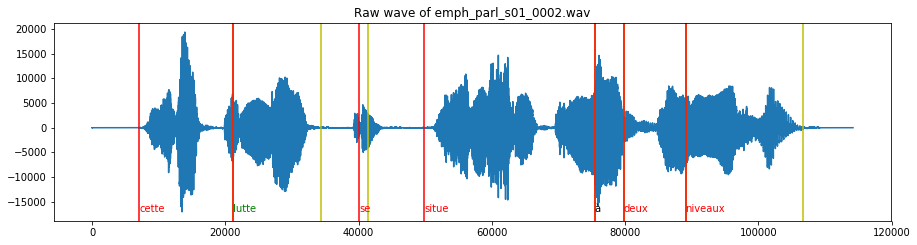

In [15]:
def sig_plot(DF1) :
    fig = plt.figure(figsize=(15, 8))
    ax1 = fig.add_subplot(211)
    ax1.set_title('Raw wave of '+ DF1.ID_wav.values[0])
    audio_path = '.'+DF1.Path.values[0]
    #samples, sr= librosa.load(audio_path)
    sample_rate, samples = wavfile.read(audio_path)
    ax1.plot(samples)

    xcoords = [(x,y) for x,y in zip(DF1.Time_begin, DF1.Time_end) ]
    xcoords = np.around(xcoords,5)

    words = DF1.Word.values
    i = 0
    pred = DF1.Pred.values
    labels = DF1.Label.values
    for xc in xcoords:
        ax1.axvline(x=xc[0]*sample_rate, c='r')
        ax1.axvline(x=xc[1]*sample_rate, c='y')
        c = 'black'
        if labels[i] & pred[i] :
            c = 'green'
        elif pred[i] & ~labels[i] :
            c = 'red'
        ax1.text(xc[0]*sample_rate, min(samples), words[i], color=c, fontsize=10)
        i+=1
    return samples, sample_rate

DF_test.Pred = pred
samples, sr = sig_plot(DF_test[:7])
ipd.Audio(samples, rate = sr)